In [2]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load the data

In [5]:
dataset_file = Path("/fast/mbonse/s4/30_data/s4_datasets/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/01_position_flux/implementation_tests/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [6]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [7]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/x1_fake_planet_experiments/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [20]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(12.)
fake_planet_config["separation"] = 30
fake_planet_config["planet_position"] = [0., 0., 30, 20.]

In [21]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Load the new code

In [22]:
from fours.position_flux.pca import PCANoiseModel
from fours.position_flux.negfc import NegFC

In [23]:
fake_planet_config["planet_position"]

[0.0, 0.0, 30, 20.0]

In [58]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"],
    init_pos_angle=fake_planet_config["planet_position"][-1],
    init_magnitude=12.,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",
)

In [59]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=200,
    approx_svd=2000)

In [60]:
science_data_torch_with_planet = torch.tensor(
    data_with_fake_planet, dtype=torch.float32)
science_data_torch = torch.tensor(
    science_data, dtype=torch.float32)

In [61]:
# move everything to the GPU
negfc = negfc.to("cuda")
pca_model = pca_model.to("cuda")
science_data_torch = science_data_torch.to("cuda")
science_data_torch_with_planet = science_data_torch_with_planet.to("cuda")

In [62]:
after_negfc = negfc(science_data_torch_with_planet)

In [63]:
pca_model.update_noise_model(science_data_torch_with_planet)
after_pca_with_planet = pca_model(science_data_torch_with_planet)

pca_model.update_noise_model(after_negfc)
after_pca_neg_fc = pca_model(after_negfc)

pca_model.update_noise_model(science_data_torch)
after_pca_without_planet = pca_model(science_data_torch)

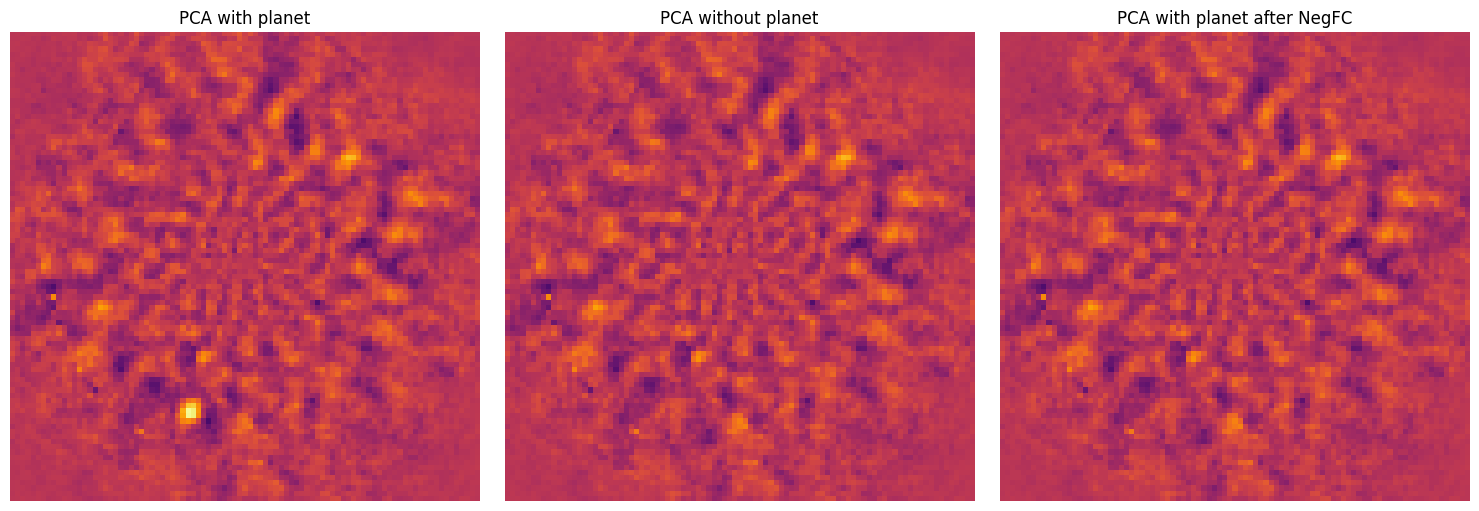

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(after_pca_with_planet.cpu().detach().numpy(), cmap="inferno", vmin=-1., vmax=1.)
ax1.set_title("PCA with planet")
ax1.axis("off")

ax2.imshow(after_pca_without_planet.cpu().detach().numpy(), cmap="inferno", vmin=-1., vmax=1.)
ax2.set_title("PCA without planet")
ax2.axis("off")

ax3.imshow(after_pca_neg_fc.cpu().detach().numpy(), 
           cmap="inferno", vmin=-1., vmax=1.)
ax3.set_title("PCA with planet after NegFC")
ax3.axis("off")

plt.tight_layout()

In [65]:
difference = after_pca_neg_fc.cpu().detach().numpy() - after_pca_without_planet.cpu().detach().numpy()

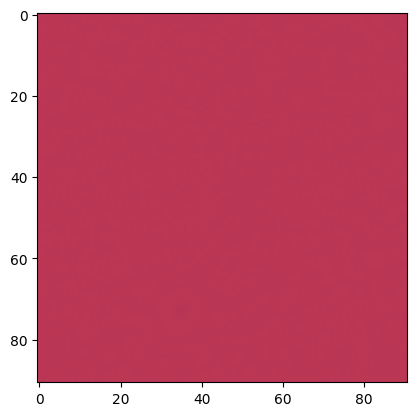

In [66]:
plt.imshow(difference, cmap="inferno", vmin=-1., vmax=1.)

In [67]:
np.max(difference)

0.007395543

# Code for the loss function

In [255]:
# code for the hessian
import torch
import torch.nn.functional as F

def gaussian_kernel1d(sigma, order, radius):
    """Create a 1D Gaussian kernel of a given order and sigma."""
    x = torch.arange(-radius, radius + 1, dtype=torch.float32)
    if order == 0:
        kernel = torch.exp(-0.5 * (x / sigma) ** 2)
    elif order == 1:
        kernel = -x / sigma ** 2 * torch.exp(-0.5 * (x / sigma) ** 2)
    elif order == 2:
        kernel = (x ** 2 / sigma ** 4 - 1 / sigma ** 2) * torch.exp(-0.5 * (x / sigma) ** 2)
    else:
        raise ValueError('Order must be 0, 1, or 2')
    kernel /= kernel.abs().sum()
    return kernel

def gaussian_kernel2d(sigma, order_x, order_y, radius):
    """Create a 2D Gaussian kernel by computing the outer product of two 1D Gaussian kernels."""
    kernel_x = gaussian_kernel1d(sigma, order_x, radius)
    kernel_y = gaussian_kernel1d(sigma, order_y, radius)
    kernel_2d = torch.outer(kernel_y, kernel_x)
    return kernel_2d

def hessian_matrix(
        image, 
        Hxx_kernel, Hxy_kernel, Hyy_kernel):
    
    # Reshape kernels for convolution
    Hxx_kernel = Hxx_kernel.view(1, 1, *Hxx_kernel.shape)
    Hxy_kernel = Hxy_kernel.view(1, 1, *Hxy_kernel.shape)
    Hyy_kernel = Hyy_kernel.view(1, 1, *Hyy_kernel.shape)
    
    # Add batch and channel dimensions to the image
    image = image.unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the kernels
    padding = (Hxx_kernel.shape[-1] - 1) // 2
    Hxx = F.conv2d(image, Hxx_kernel, padding=padding)
    Hxy = F.conv2d(image, Hxy_kernel, padding=padding)
    Hyy = F.conv2d(image, Hyy_kernel, padding=padding)
    
    # Remove the batch and channel dimensions
    Hxx = Hxx.squeeze(0).squeeze(0)
    Hxy = Hxy.squeeze(0).squeeze(0)
    Hyy = Hyy.squeeze(0).squeeze(0)
    
    return Hxx, Hxy, Hyy

In [274]:
# write a function which creates the mask
def create_aperture_mask(
        image_shape, 
        separation_pixel, 
        pos_angle_deg,
        aperture_radius):
    
    # calculate the x, y position of the mask
    image_center = np.array(image_shape) / 2
    image_center -= 0.5
    
    # + 90 deg for the conventions in HCI
    y_shift = separation_pixel * np.cos(np.deg2rad(pos_angle_deg + 90))
    x_shift = separation_pixel * np.sin(np.deg2rad(pos_angle_deg + 90))
    
    y_pos = image_center[0] + y_shift
    x_pos = image_center[1] + x_shift
    
    # create a round mask around the (x_pos, y_pos) position with radius = aperture_radius
    y, x = np.ogrid[
           -x_pos:image_shape[0] - x_pos, 
           -y_pos:image_shape[1] - y_pos]
    
    mask = x**2 + y**2 <= aperture_radius**2
    
    return mask


# write a class for the loss function
class NegFCLoss(torch.nn.Module):
    
    def __init__(
            self, 
            residual_shape,
            separation_pixel,
            pos_angle_deg,
            aperture_radius,
            metric_function="mse",
            sigma_hessian=1.8
    ):
        super(NegFCLoss, self).__init__()
        
        # Create the mask and transform it to a tensor
        self.loss_mask = create_aperture_mask(
            image_shape=residual_shape, 
            separation_pixel=separation_pixel, 
            pos_angle_deg=pos_angle_deg,
            aperture_radius=aperture_radius)
        
        # define the metric function
        self.metric_function = metric_function
        
        # if the metric function is hessian create the kernels
        if self.metric_function == "hessian":
            radius = int(3 * sigma_hessian + 0.5)
            Hxx_kernel = gaussian_kernel2d(sigma_hessian, 2, 0, radius)
            Hxy_kernel = gaussian_kernel2d(sigma_hessian, 1, 1, radius)
            Hyy_kernel = gaussian_kernel2d(sigma_hessian, 0, 2, radius)
            
            # register the kernels
            self.register_buffer("Hxx_kernel", Hxx_kernel)
            self.register_buffer("Hxy_kernel", Hxy_kernel)
            self.register_buffer("Hyy_kernel", Hyy_kernel)
        
    def forward(self, residual_image):
        if self.metric_function == "hessian":
            Hxx, Hxy, Hyy = hessian_matrix(
                residual_image, 
                self.Hxx_kernel, 
                self.Hxy_kernel, 
                self.Hyy_kernel)
            
            # calculate the determinant of the hessian
            hes_det = (Hxx*Hyy) - (Hxy*Hxy)
            
            # apply the mask
            selected_pixel = hes_det[self.loss_mask]
        
        elif self.metric_function == "mse":
            # apply the mask
            selected_pixel = residual_image[self.loss_mask]
        
        else:
            raise ValueError("The metric function is not implemented.")
        
        # calculate the loss
        loss = torch.sum(selected_pixel**2)
        
        return loss

# Implement a simple minimization

In [345]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=200,
    approx_svd=5000)

In [346]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"] + 2,
    init_pos_angle=fake_planet_config["planet_position"][-1] - 4,
    init_magnitude=11.5,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",)

In [347]:
# create the loss function
negfc_loss = NegFCLoss(
    residual_shape=science_data.shape[1:],
    separation_pixel=fake_planet_config["separation"],
    pos_angle_deg=fake_planet_config["planet_position"][-1],
    aperture_radius=5,
    metric_function="mse")

In [348]:
# move everything to the GPU
science_data_torch_with_planet = science_data_torch_with_planet.to(0)
negfc = negfc.to(0)
pca_model = pca_model.to(0)
negfc_loss = negfc_loss.to(0)

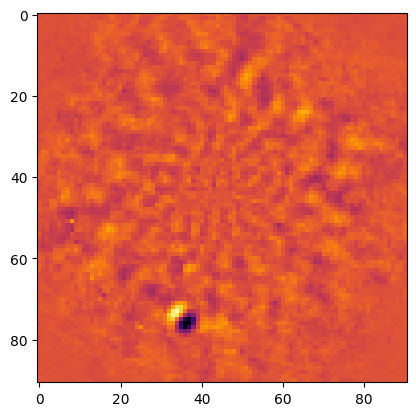

In [349]:
update_basis = True

after_negfc = negfc(science_data_torch_with_planet)

if update_basis:
    pca_model.update_noise_model(after_negfc)

after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

In [350]:
from torch import optim
from tqdm import tqdm

In [351]:
input_data = science_data_torch_with_planet

# create the optimizer
optimizer_kwargs = {
    "max_iter": 20,
    "history_size": 10}

optimizer = optim.LBFGS(
    negfc.parameters(),
    **optimizer_kwargs)

In [352]:
for j in range(40):
    print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())
    after_negfc = negfc(science_data_torch_with_planet)
    pca_model.update_noise_model(after_negfc)

    # iterate for 100 steps
    for i in range(20):
        def closure():        
            optimizer.zero_grad()
            after_negfc = negfc(science_data_torch_with_planet)
            after_pca_neg_fc = pca_model(after_negfc)
            
            # apply the loss function
            loss = negfc_loss(after_pca_neg_fc)
            loss.backward()
            return loss

        optimizer.step(closure)

32.0 16.0 11.5
31.4299259185791 18.09294891357422 12.049007415771484
30.78803825378418 19.713863372802734 12.155341148376465
30.42124366760254 20.36056900024414 12.094807624816895
30.243276596069336 20.585966110229492 12.03698444366455
30.15336799621582 20.664390563964844 12.000595092773438
30.10567283630371 20.69206428527832 11.979239463806152
30.07958221435547 20.70146942138672 11.966926574707031
30.065093994140625 20.704143524169922 11.959832191467285
30.056926727294922 20.704750061035156 11.955801010131836
30.05227279663086 20.704612731933594 11.95349407196045
30.049686431884766 20.70427703857422 11.952170372009277
30.048168182373047 20.70410919189453 11.951398849487305
30.047332763671875 20.703899383544922 11.950961112976074
30.046815872192383 20.703907012939453 11.95073127746582
30.046499252319336 20.703908920288086 11.950581550598145
30.046369552612305 20.703784942626953 11.950499534606934
30.046239852905273 20.70370101928711 11.950416564941406
30.046192169189453 20.703704833984

In [360]:
x_shift_res = negfc.separation.item() * np.cos(np.deg2rad(negfc.pos_angle.item()))
y_shift_res = negfc.separation.item() * np.sin(np.deg2rad(negfc.pos_angle.item()))

print(x_shift_res, y_shift_res)

28.1058084999848 10.622334166902155


In [361]:
x_shift = 30 * np.cos(np.deg2rad(20))
y_shift = 30 * np.sin(np.deg2rad(20))

print(x_shift, y_shift)

28.19077862357725 10.260604299770064


In [362]:
np.abs(y_shift - y_shift_res)

0.361729867132091

In [363]:
np.abs(x_shift - x_shift_res)

0.08497012359244849

In [364]:
brightness_diff = np.abs(mag2flux_ratio(12.) - mag2flux_ratio(negfc.magnitude.item()))

In [365]:
brightness_diff / mag2flux_ratio(12.)

0.04672871160971537

In [367]:
np.abs(negfc.magnitude.item() - 12)

0.04958534240722656